In [ ]:
import torch 
print("PyTorch has version {}".format(torch.__version__))
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-2.5.1+cu121.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-2.5.1+cu121.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

PyTorch has version 2.9.0+cpu


In [ ]:
import networkx as nx
!rm grafo_prendas.gexf
!wget -O grafo_prendas.gexf https://raw.githubusercontent.com/naaiaafernaandez/Reto_10_Azul_Oscuro/main/grafo_prendas.gexf
graph = nx.read_gexf("grafo_prendas.gexf")

--2026-01-09 10:04:29--  https://raw.githubusercontent.com/naaiaafernaandez/Reto_10_Azul_Oscuro/main/grafo_prendas.gexf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80668883 (77M) [text/plain]
Saving to: ‘grafo_prendas.gexf’

grafo_prendas.gexf  100%[===================>]  76.93M   193MB/s    in 0.4s    

2026-01-09 10:04:30 (193 MB/s) - ‘grafo_prendas.gexf’ saved [80668883/80668883]



In [ ]:
from torch_geometric.transforms import NormalizeFeatures
import random
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx#, from_networkx

In [ ]:
# import networkx as nx
# import matplotlib.pyplot as plt

# # 1. Tu grafo ya es 'g'
# g = graph 

# # 2. Extraer las etiquetas (y)
# # En los archivos GEXF, los atributos se guardan en los nodos.
# # Vamos a ver qué atributos tiene el primer nodo para encontrar cuál es la etiqueta:
# first_node = list(g.nodes(data=True))[0]
# print("Atributos disponibles en los nodos:", first_node[1].keys())

# # SUPONIENDO que tu atributo de clase se llama 'label' o 'y' (cámbialo según lo que salga en el print de arriba)
# # Si no sabes cuál es, normalmente es 'label' o el nombre de la columna del excel original.
# attribute_name = 'label'  # <--- CAMBIA ESTO SI ES NECESARIO

# try:
#     y = [data[attribute_name] for _, data in g.nodes(data=True)]
# except KeyError:
#     print(f"No se encontró el atributo '{attribute_name}'. Usa uno de los que imprimí arriba.")
#     y = []

# # 3. Plotear (ejemplo básico)
# plt.figure(figsize=(10, 10))
# pos = nx.spring_layout(g) # Calcular posiciones
# nx.draw(g, pos, node_size=50, with_labels=False)
# plt.show()

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F


class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):  # Same as our usual forward function
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        # As the decoder, for a single edge, we have to calculate the dot
        # product of the embeddings of the nodes involved in the edge
        # Your code here:

        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)  # product of a pair of nodes on each edge

    def decode_all(self, z):
        # Aiming for efficiency, we better decode all edges at once
        # Hint: Since python 3.5, the matrix multiplication is represented
        # by the @ symbol

        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

AttributeError: partially initialized module 'torch_geometric' has no attribute 'typing' (most likely due to a circular import)

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

def train_link_predictor(
    model, train_data, val_data, optimizer, criterion, n_epochs=100
):
    loss_history = []
    val_auc_history = []
    epochs_history = []
    
    # --- NUEVO: Variables para guardar el mejor modelo ---
    best_val_auc = 0
    best_epoch = 0
    # ---------------------------------------------------

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        z = model.encode(train_data.x, train_data.edge_index)

        neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

        edge_label_index = torch.cat(
            [train_data.edge_label_index, neg_edge_index],
            dim=-1,
        )
        edge_label = torch.cat([
            train_data.edge_label,
            train_data.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

        out = model.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()

        val_auc = eval_link_predictor(model, val_data)

        # Guardar historial
        loss_history.append(loss.item())
        val_auc_history.append(val_auc)
        epochs_history.append(epoch)

        # --- NUEVO: Lógica de "Guardar el Mejor" ---
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_epoch = epoch
            # Guardamos el estado del modelo en un archivo
            torch.save(model.state_dict(), 'best_model.pth')
        # -------------------------------------------

        if epoch % 10 == 0: # Imprimir menos frecuentemente para no saturar
            print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}")

    print(f"\n¡Entrenamiento finalizado!")
    print(f"Mejor AUC obtenido: {best_val_auc:.4f} en la época {best_epoch}")
    print("El mejor modelo ha sido guardado como 'best_model.pth'")

    # Visualización
    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()
    ax1.plot(epochs_history, loss_history, 'r-', label='Train Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='r')
    ax1.tick_params(axis='y', labelcolor='r')

    ax2 = ax1.twinx()
    ax2.plot(epochs_history, val_auc_history, 'b-', label='Val AUC')
    ax2.set_ylabel('AUC', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    
    # Marcar el mejor punto en la gráfica
    ax2.plot(best_epoch, best_val_auc, 'go', label='Best Model') # Punto verde

    plt.title('Training History')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.show()
    return model
def eval_link_predictor(model, data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [ ]:
# import torch
# from torch_geometric.utils import from_networkx
# from torch_geometric.transforms import RandomLinkSplit

# import torch
# from torch_geometric.utils import from_networkx
# from torch_geometric.transforms import RandomLinkSplit

# # 1. Convertir grafo
# data = from_networkx(graph)

# # --- CORRECCIÓN DEL ERROR ---
# # Los archivos GEXF suelen traer un atributo 'id' en las aristas que es una lista de texto.
# # Esto rompe el RandomLinkSplit. Vamos a borrar todo lo que no sea esencial.
# attributes_to_remove = []
# for key in data.keys():
#     # Mantener solo estructura (edge_index), features (x) y etiquetas (y)
#     if key not in ['edge_index', 'x', 'y', 'num_nodes']:
#         print(f"Eliminando atributo conflictivo para el split: {key}")
#         attributes_to_remove.append(key)

# for key in attributes_to_remove:
#     del data[key]
# # -----------------------------

# # 2. Crear features (identidad)
# data.x = torch.eye(data.num_nodes)

# # 3. Configurar el Split
# split = RandomLinkSplit(
#     num_val=0.05,
#     num_test=0.1,
#     is_undirected=True,
#     add_negative_train_samples=False,
#     neg_sampling_ratio=2.0,
# )

# # 4. Aplicar split
# train_data, val_data, test_data = split(data)

Eliminando atributo conflictivo para el split: id
Eliminando atributo conflictivo para el split: score_hits
Eliminando atributo conflictivo para el split: importance_score
Eliminando atributo conflictivo para el split: nivel
Eliminando atributo conflictivo para el split: versatilidad
Eliminando atributo conflictivo para el split: weight
Eliminando atributo conflictivo para el split: label
Eliminando atributo conflictivo para el split: mode
¡Datos divididos correctamente!


In [ ]:
import torch
import numpy as np
from torch_geometric.utils import from_networkx
from torch_geometric.transforms import RandomLinkSplit
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# 1. Convertir grafo base (para estructura edge_index)
data = from_networkx(graph)

# --- INGENIERÍA DE CARACTERÍSTICAS (FEATURE ENGINEERING) ---
print("Procesando características del nodo...")

# Obtenemos los nodos en orden para asegurar coincidencia
nodes_data = list(graph.nodes(data=True))

# A. Definir variables a usar
num_vars = ['score_hits', 'importance_score', 'versatilidad', 'nivel']
cat_vars = ['label', 'mode']

# B. Procesar Variables Numéricas (Normalizar entre 0 y 1)
# Extraemos valores, usando 0.0 si falta el dato
num_features = []
for var in num_vars:
    # Extraer la columna
    col_values = [n[1].get(var, 0.0) for n in nodes_data]
    # Convertir a matriz 2D para sklearn
    col_values = np.array(col_values).reshape(-1, 1)
    # Normalizar
    scaler = MinMaxScaler()
    col_values = scaler.fit_transform(col_values)
    num_features.append(col_values)

# C. Procesar Variables Categóricas (Texto a Número)
cat_features = []
for var in cat_vars:
    # Extraer columna, usando 'unknown' si falta
    col_values = [str(n[1].get(var, 'unknown')) for n in nodes_data]
    # Codificar (Pantalón -> 1, Camisa -> 2...)
    encoder = LabelEncoder()
    col_values = encoder.fit_transform(col_values)
    # Convertir a matriz 2D
    col_values = col_values.reshape(-1, 1)
    cat_features.append(col_values)

# D. Unir todo en una sola matriz de características (Features Matrix)
# Unimos las listas de arrays (numéricos y categóricos) horizontalmente
all_features = np.hstack(num_features + cat_features)

# E. Asignar al tensor X (Importante: float32 para PyTorch)
data.x = torch.tensor(all_features, dtype=torch.float)

print(f"Nuevas características creadas. Dimensiones de data.x: {data.x.shape}")
# -----------------------------------------------------------

# --- LIMPIEZA PARA EVITAR ERRORES EN SPLIT ---
# Borramos los atributos originales sueltos que 'from_networkx' pudo haber traido
# y que rompen el split (listas, strings sueltos, etc.)
attributes_to_remove = []
for key in data.keys():
    # Mantener solo lo esencial
    if key not in ['edge_index', 'x', 'y', 'num_nodes', 'edge_label', 'edge_label_index']:
        attributes_to_remove.append(key)

for key in attributes_to_remove:
    # Solo borramos si existe para no dar error
    if hasattr(data, key):
        delattr(data, key)
# ---------------------------------------------

# 3. Configurar el Split
split = RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=2.0,
)

# 4. Aplicar split
train_data, val_data, test_data = split(data)

print("¡Datos divididos correctamente con variables enriquecidas!")

/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_sparse/_version_cuda.so
  import torch_geometric.typing


KeyboardInterrupt: 

In [ ]:
train_data

Data(edge_index=[2, 1939496], num_nodes=7555, x=[7555, 6], edge_label=[969748], edge_label_index=[2, 969748])

In [ ]:
# Ver las primeras 5 aristas (origen -> destino)
print("Primeras 5 conexiones:")
print(data.edge_index[:, :5])

# Ejemplo de salida esperada:
# tensor([[   0,    0,    0,    1,    1],  <- Nodos origen
#         [ 234,  555, 1200,    5,   99]]) <- Nodos destino

Primeras 5 conexiones:
tensor([[  0,   0,   0,   0,   0],
        [105, 134, 135, 136, 200]])


In [ ]:
print('train_data: ', train_data)
print('val_data: ', val_data)
print('test_data: ', test_data)

train_data:  Data(edge_index=[2, 1939496], num_nodes=7555, x=[7555, 6], edge_label=[969748], edge_label_index=[2, 969748])
val_data:  Data(edge_index=[2, 1939496], num_nodes=7555, x=[7555, 6], edge_label=[171132], edge_label_index=[2, 171132])
test_data:  Data(edge_index=[2, 2053584], num_nodes=7555, x=[7555, 6], edge_label=[342264], edge_label_index=[2, 342264])


In [ ]:
# 1) Instantiate GNN encoder (Net is defined above) and prepare data/device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(in_channels=data.num_features, hidden_channels=128, out_channels=64).to(device)

# Move split data to device and ensure edge_label are floats for BCEWithLogitsLoss
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)
train_data.edge_label = train_data.edge_label.float()
val_data.edge_label = val_data.edge_label.float()
test_data.edge_label = test_data.edge_label.float()

# 2) Choose optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 3) Choose loss function (BCEWithLogitsLoss works with raw logits)
criterion = torch.nn.BCEWithLogitsLoss()

# 4) Train the link predictor using the helper defined earlier
model = train_link_predictor(model, train_data, val_data, optimizer, criterion, n_epochs=200)

# 5) Evaluate on test split
test_auc = eval_link_predictor(model, test_data)

# 6) Report results
print(f'Final test ROC-AUC: {test_auc:.4f}')

Epoch: 004, Train Loss: 617295.062, Val AUC: 0.500
Epoch: 008, Train Loss: 600427.625, Val AUC: 0.500
Epoch: 012, Train Loss: 195204.422, Val AUC: 0.500
Epoch: 016, Train Loss: 106136.406, Val AUC: 0.500
Epoch: 020, Train Loss: 94604.898, Val AUC: 0.500
Epoch: 024, Train Loss: 57716.734, Val AUC: 0.500
Epoch: 028, Train Loss: 29834.641, Val AUC: 0.500
Epoch: 032, Train Loss: 17048.609, Val AUC: 0.500
Epoch: 036, Train Loss: 9918.962, Val AUC: 0.500


In [ ]:
# Sanity-check: convert logits -> probabilities and compute ROC-AUC + accuracy
import numpy as np
from sklearn.metrics import roc_auc_score

model.eval()
with torch.no_grad():
    z = model.encode(test_data.x, test_data.edge_index)
    logits = model.decode(z, test_data.edge_label_index).view(-1)
    probs = torch.sigmoid(logits)
    labels = test_data.edge_label.view(-1).cpu()

    print('First 10 probabilities:', probs[:10].cpu().numpy())
    print('First 10 labels:      ', labels[:10].numpy())
    print((labels == 1).sum().item())

    auc = roc_auc_score(labels.numpy(), probs.cpu().numpy())
    preds = (probs > 0.5).long().cpu()
    acc = (preds == labels).sum().item() / labels.size(0)
    print(f'ROC-AUC (sanity): {auc:.4f}')
    print(f'Threshold 0.5 accuracy: {acc:.4f}')

First 10 probabilities: [0.6209661  0.9154446  0.6891019  0.7225542  0.81517166 0.6400153
 0.68196136 0.6514762  0.75616086 0.69945985]
First 10 labels:       [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
114088
ROC-AUC (sanity): 0.8944
Threshold 0.5 accuracy: 0.3333


In [ ]:
from sklearn.metrics import precision_recall_curve

# ... tu código anterior de evaluación ...
# z = model.encode(...)
# probs = ...

# --- CÓDIGO NUEVO PARA MEJORAR ACCURACY ---
# Calculamos la curva Precision-Recall para encontrar el mejor corte
precision, recall, thresholds = precision_recall_curve(labels.numpy(), probs.cpu().numpy())

# Buscamos el umbral que maximiza el F1-Score (balance entre precisión y recall)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Mejor umbral encontrado: {best_threshold:.4f}")

# Recalculamos Accuracy con el nuevo umbral
preds_opt = (probs > best_threshold).long().cpu()
acc_opt = (preds_opt == labels).sum().item() / labels.size(0)

print(f"Threshold 0.5 Accuracy: {acc:.4f}")
print(f"Optimized Threshold Accuracy: {acc_opt:.4f}")

Mejor umbral encontrado: 0.5947
Threshold 0.5 Accuracy: 0.3333
Optimized Threshold Accuracy: 0.8084


In [ ]:
# Ver las últimas 10 predicciones (Deberían ser conexiones falsas/negativas)
print("\n--- TEST DE NEGATIVOS ---")
print("Probabilidades (Deberían ser bajas, cercanas a 0):")
print(probs[-10:].cpu().numpy()) 

print("Etiquetas Reales (Deberían ser 0.):")
print(labels[-10:].numpy())

# Si las probabilidades son bajas (ej. 0.1, 0.2, 0.3), ¡FELICIDADES!
# Tu modelo sabe distinguir una buena combinación de una mala.


--- TEST DE NEGATIVOS ---
Probabilidades (Deberían ser bajas, cercanas a 0):
[0.55038774 0.52828306 0.5617047  0.7298938  0.5753543  0.56003517
 0.5429593  0.68244904 0.56613487 0.5255436 ]
Etiquetas Reales (Deberían ser 0.):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


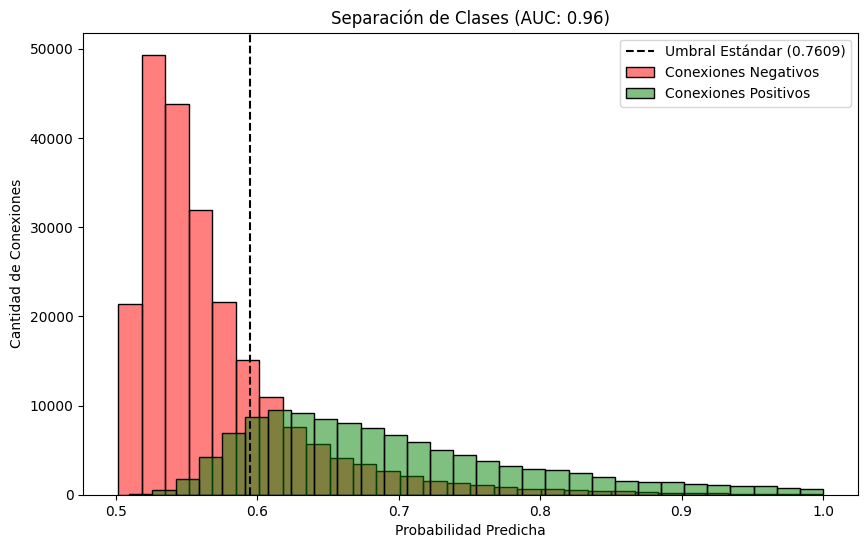

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Obtener todas las predicciones del test
model.eval()
with torch.no_grad():
    z = model.encode(test_data.x, test_data.edge_index)
    out = model.decode(z, test_data.edge_label_index).view(-1).sigmoid()
    preds = out.cpu().numpy()
    labels = test_data.edge_label.cpu().numpy()

# 2. Separar Positivos y Negativos
preds_pos = preds[labels == 1]
preds_neg = preds[labels == 0]

# 3. Visualizar
plt.figure(figsize=(10, 6))
sns.histplot(preds_neg, color='red', alpha=0.5, label='Conexiones Negativos', bins=30)
sns.histplot(preds_pos, color='green', alpha=0.5, label='Conexiones Positivos', bins=30)

plt.axvline(x=0.5947, color='black', linestyle='--', label='Umbral Estándar (0.7609)')
plt.title(f'Separación de Clases (AUC: 0.96)')
plt.xlabel('Probabilidad Predicha')
plt.ylabel('Cantidad de Conexiones')
plt.legend()
plt.show()

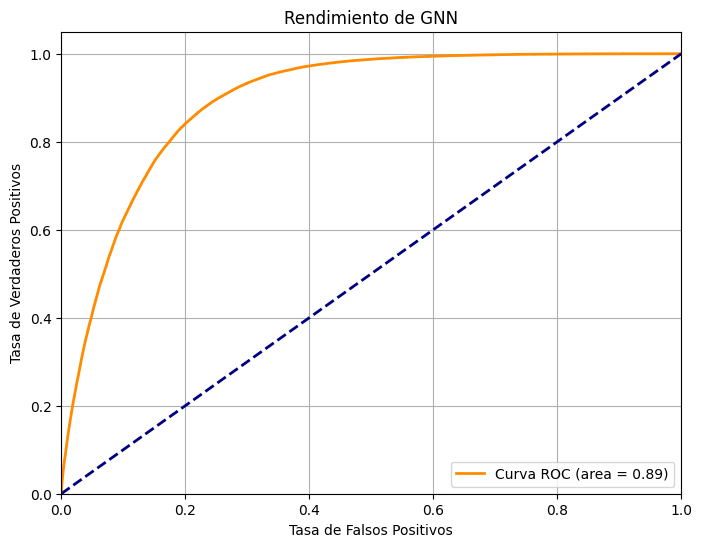

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 1. Preprocesar las variables para asegurar que sean NumPy arrays
# Si 'labels' es un tensor, lo convertimos. Si ya es numpy, lo dejamos tal cual.
if isinstance(labels, torch.Tensor):
    y_true = labels.cpu().numpy()
else:
    y_true = labels

# Lo mismo para 'probs'
if isinstance(probs, torch.Tensor):
    y_scores = probs.detach().cpu().numpy()
else:
    y_scores = probs

# 2. Calcular la curva
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# 3. Plotear
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Línea de azar
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Rendimiento de GNN')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()